In [1]:
#Prepare initial values
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Perspective Transform
src = np.array([[688,450],[1040,673],[271,673],[594,450]], np.float32)
dst_points = np.array([[1000,0],[1000,720],[250,720],[250,0]], np.float32)

M = cv2.getPerspectiveTransform(src, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src)

        



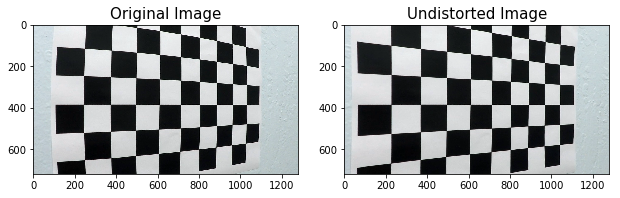

In [3]:
#Visualize the original image versus undistorted image
%matplotlib inline
img = cv2.imread('./camera_cal/calibration5.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

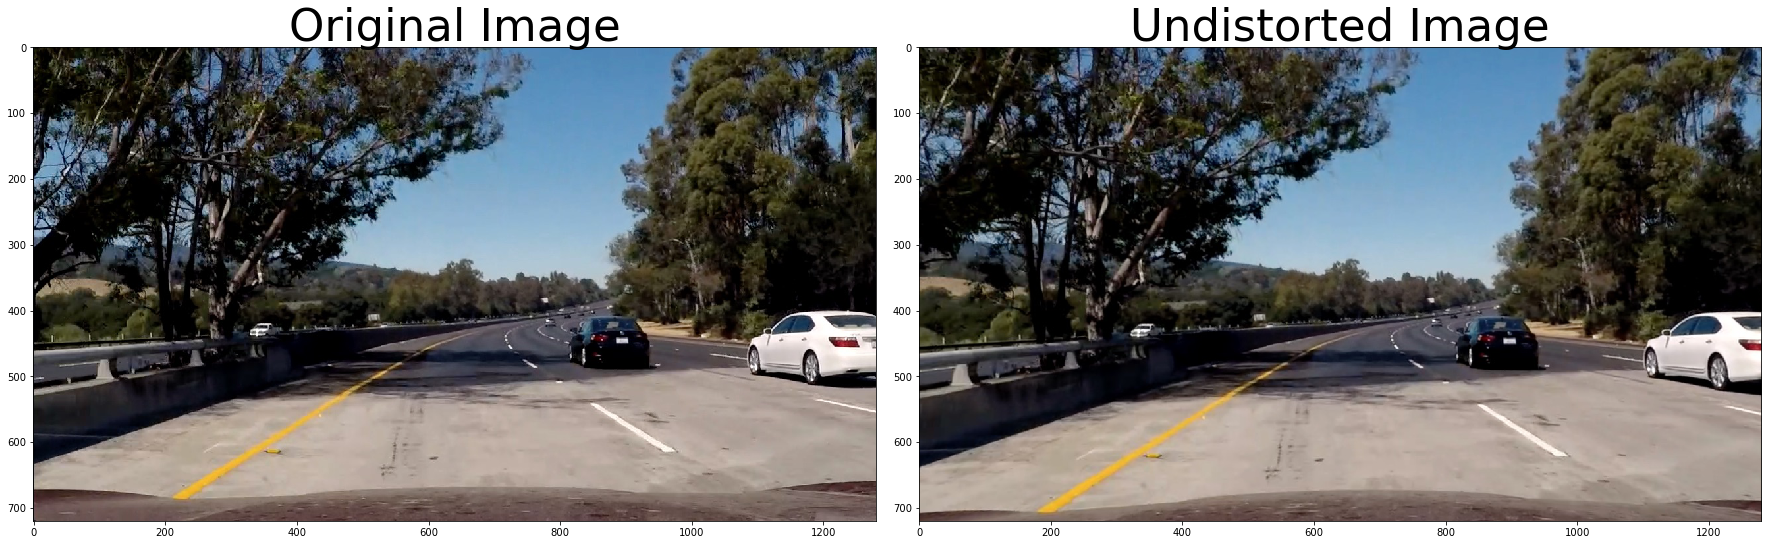

In [28]:
#Visualize distortion correction on test image from vehicle
%matplotlib inline
img = cv2.imread('./test_images/test5.jpg')
dst = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=45)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Binary Functions

In [2]:
#Thresholded binary image functions
def hls_select(img, thresh=(180, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(100, 200)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_channel = hsv[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

def rgb_select(img, thresh=(200,255)):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r_channel = rgb[:,:,0]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary_output

def abs_sobelx_thresh(img, sobel_kernel=5, thresh=(35, 150)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sxbinary

def abs_sobely_thresh(img, sobel_kernel=5, thresh=(35, 150)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sybinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(150, 230)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(1.7, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

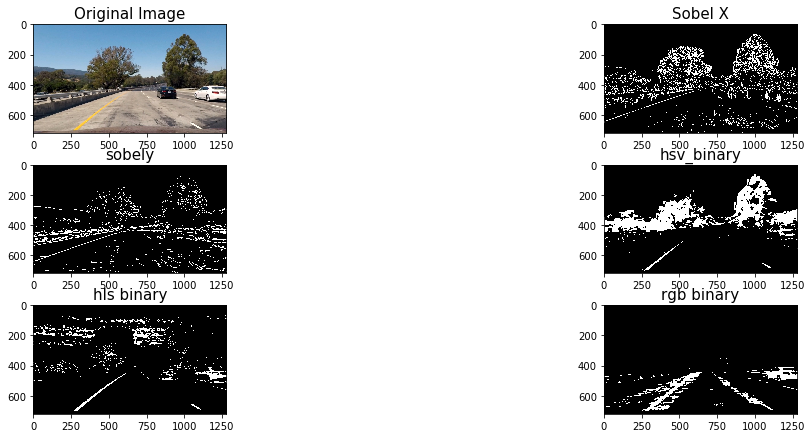

In [28]:
%matplotlib inline
img = cv2.imread('./test_images/test1.jpg')
img = cal_undistort(img)
hls_binary = hls_select(img, (130,255))
rgb_binary = rgb_select(img, (200,255))
sobelx = abs_sobelx_thresh(img,5,(15,255))
sobely = abs_sobely_thresh(img, 5, (30,150))
magnitude_thresh = mag_thresh(img,5,(20,100))
hsv_binary = hsv_select(img,(20, 50))
direction_threshold = dir_threshold(img, 3, (1.3,np.pi/2))

f, axs = plt.subplots(3, 2, figsize=(16, 6))
f.tight_layout()
axs[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
axs[0,0].set_title('Original Image', fontsize=15)
axs[0,1].imshow(sobelx, cmap='gray')
axs[0,1].set_title('Sobel X', fontsize=15)
axs[1,0].imshow(sobely, cmap='gray')
axs[1,0].set_title('sobely', fontsize=15)
axs[1,1].imshow(hsv_binary, cmap='gray')
axs[1,1].set_title('hsv_binary', fontsize=15)
axs[2,0].imshow(hls_binary, cmap='gray')
axs[2,0].set_title('hls binary', fontsize=15)
axs[2,1].imshow(rgb_binary, cmap='gray')
axs[2,1].set_title('rgb binary', fontsize=15)
#plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.)
# We can see that the s channel and r channel are providing the best results

## Image Pipeline Functions

In [53]:
#Define a function to undistort an image. Return value is undistorted image.
def cal_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def binary_pipeline(img):
    img = cal_undistort(img)
    hls_binary = hls_select(img, (130,255))
    rgb_binary = rgb_select(img, (210,255))
    sobelx = abs_sobelx_thresh(img,5,(15,200))
    sobely = abs_sobely_thresh(img, 5, (30,150))
    hsv_binary = hsv_select(img,(20, 50))
    direction_threshold = dir_threshold(img, 3, (1,np.pi/2))
    
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(hls_binary == 1) | ((sobelx == 1) & (sobely ==1)) | (hsv_binary == 1)] = 1
    return combined_binary

def test(img):
    img = cal_undistort(img)
    hls_binary = hls_select(img, (130,255))
    rgb_binary = rgb_select(img, (210,255))
    sobelx = abs_sobelx_thresh(img,5,(15,200))
    sobely = abs_sobely_thresh(img, 5, (30,150))
    hsv_binary = hsv_select(img,(20, 50))
    direction_threshold = dir_threshold(img, 3, (1,np.pi/2))
    
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[((hls_binary == 1) & (rgb_binary == 1)) | ((hls_binary == 1) & (hsv_binary == 1)) | ((hls_binary == 1) & (sobelx == 1)) | ((hls_binary == 1) & (sobely == 1)) | ((sobelx == 1) & (rgb_binary ==1)) | (hsv_binary == 1)] = 1
    return combined_binary

def image_pipeline(img):
    img_size = (img.shape[1], img.shape[0])
    binary_img = binary_pipeline(img)
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def process_image(img):
    original_undist = cal_undistort(img)
    binary_warped = image_pipeline(img)
    ploty, left_fitx, right_fitx, avg_radius, lane_offset = get_fits(binary_warped)    
    return paint_lines(binary_warped, original_undist, ploty, left_fitx, right_fitx, avg_radius, lane_offset)

    

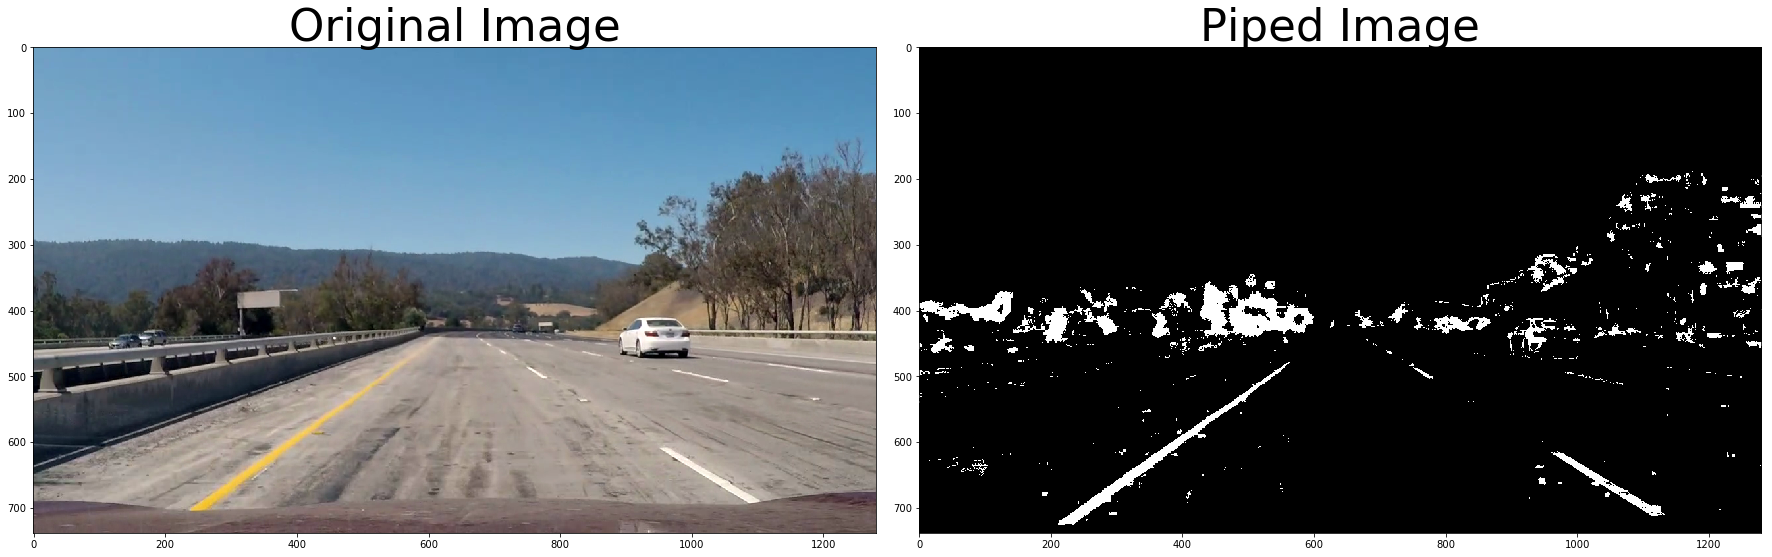

In [52]:
%matplotlib inline
img = cv2.imread('./test_images/test8.jpg')
dst = test(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=45)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Piped Image', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

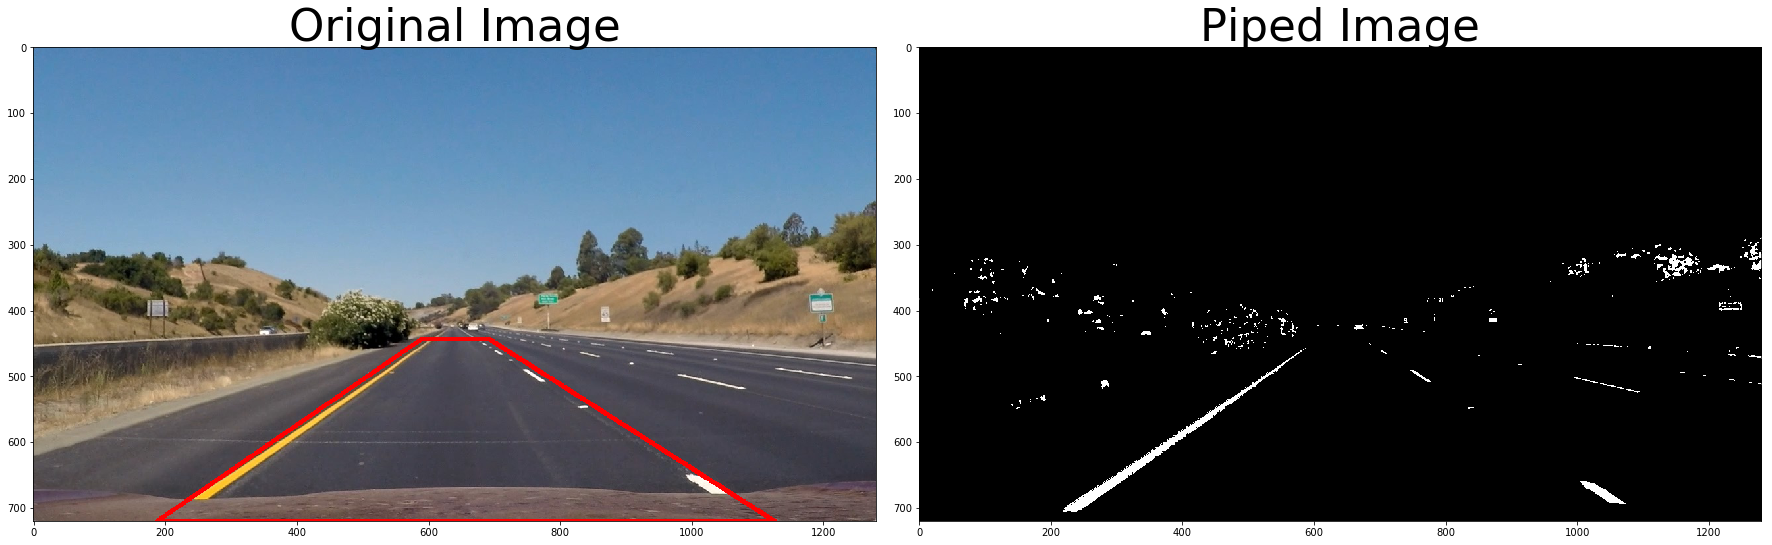

In [104]:

img = cv2.imread('./test_images/straight_lines1.jpg')
dst = binary_pipeline(img)
pts = np.array([[188,720],[590,443],[692,443],[1126,720]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(img,[pts],True,(0,0,255),5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=45)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Piped Image', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



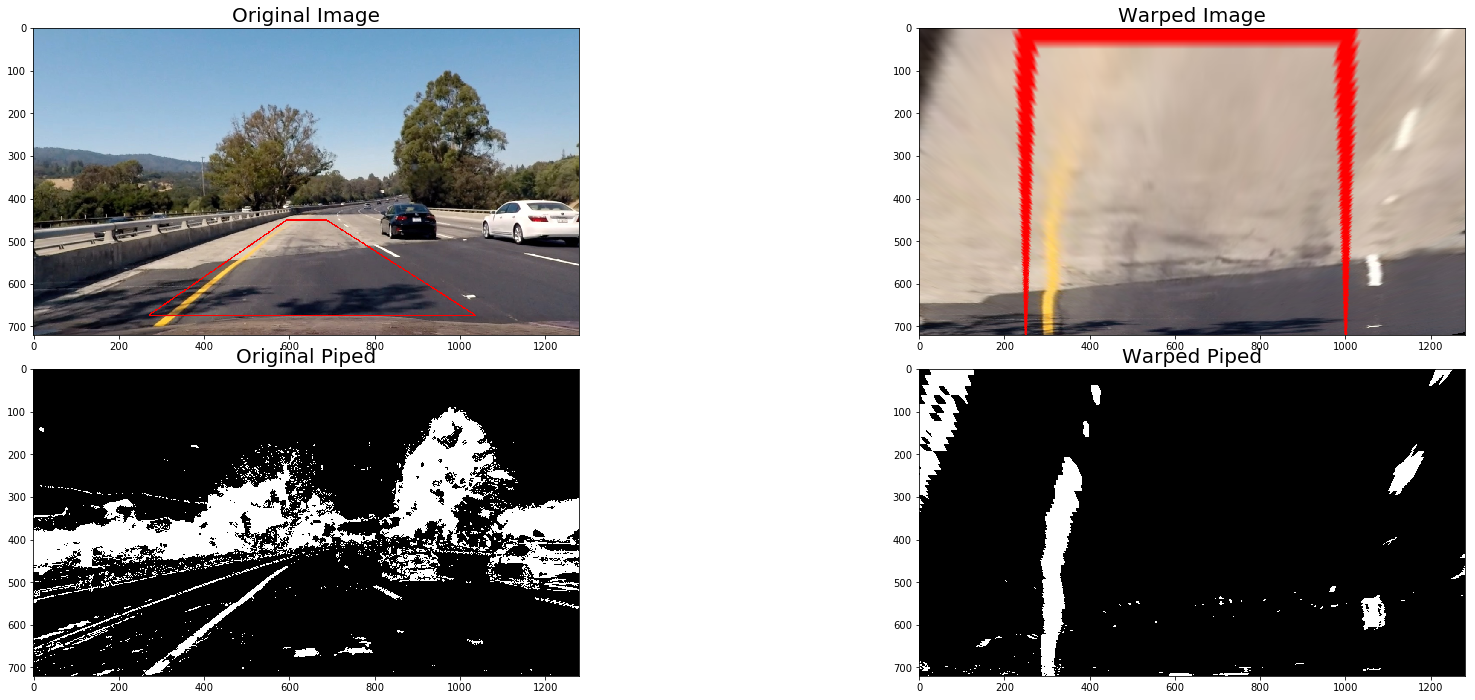

In [60]:
%matplotlib inline
img = cv2.imread('./test_images/straight_lines1.jpg')
curved_img = cv2.imread('./test_images/test4.jpg')
img = cal_undistort(curved_img)
dst = binary_pipeline(img)
img_size = (dst.shape[1], dst.shape[0])
src_int = src = np.array([[688,450],[1037,673],[271,673],[594,450]], np.int32)
src = np.array([[688,450],[1037,673],[271,673],[594,450]], np.float32)
dst_points = np.array([[1000,0],[1000,720],[250,720],[250,0]], np.float32)
pts = src_int.reshape((-1,1,2))
cv2.polylines(img,[src_int],True,(0,0,255),2)

M = cv2.getPerspectiveTransform(src, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
warped_piped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
f, axs = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axs[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0,0].set_title('Original Image', fontsize=20)
axs[0,1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axs[0,1].set_title('Warped Image', fontsize=20)
axs[1,0].imshow(dst, cmap='gray')
axs[1,0].set_title('Original Piped', fontsize=20)
axs[1,1].imshow(warped_piped, cmap='gray')
axs[1,1].set_title('Warped Piped', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

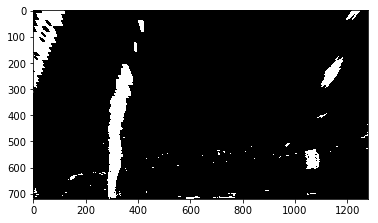

In [61]:
import numpy as np
%matplotlib inline
img = cv2.imread('./test_images/test4.jpg')

birdEyeImg = image_pipeline(img)
plt.imshow(birdEyeImg, cmap='gray')

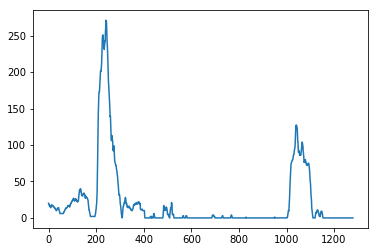

In [151]:
#histogram of pixels in lower half of bird's eye view image to identify lane positions
import numpy as np
img = cv2.imread('./test_images/test5.jpg')

binary_warped = image_pipeline(img)
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

## Fitting Lines

In [4]:
def get_fits(binary_warped):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    import random
    global frame_count
    global left_failures
    global right_failures
    global left_line
    global right_line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if (left_line.detected == True and right_line.detected == True):
        leftx, lefty, rightx, righty, left_fit, right_fit = focused_search(binary_warped, left_line.current_fit, right_line.current_fit)
    else:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = binary_warped.shape[1]/15
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    if (frame_count > 0):
        if (len(lefty) ==0):
            lefty = left_line.ally
        if (len(leftx) ==0):
            leftx = left_line.allx
        if (len(righty) ==0):
            righty = right_line.ally
        if (len(rightx) ==0):
            rightx = right_line.allx
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_curve_base = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
    right_curve_base = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]
    
    # Sanity
    if (frame_count == 0):
        left_lane_detected = True
        right_lane_detected = True
        frame_count = 1
        combined_leftx = leftx
        combined_lefty = lefty
        combined_rightx = rightx
        combined_righty = righty
        print('First frame done')
    else:
        x_base_thresh = binary_warped.shape[1]/15
        left_lane_detected = sanity(binary_warped,left_line, left_curve_base, x_base_thresh, binary_warped.shape, get_line_radius(ploty, leftx, lefty),leftx, lefty, rightx, righty)
        right_lane_detected = sanity(binary_warped,right_line, right_curve_base, x_base_thresh, binary_warped.shape, get_line_radius(ploty, rightx, righty),leftx, lefty, rightx, righty, False)
        left_line_ghostx =[] 
        left_line_ghosty =[] 
        right_line_ghostx = [] 
        right_line_ghosty = []

        combined_left = list(zip(left_line.allx, left_line.ally))
        random.shuffle(combined_left)
        left_line_ghostx[:], left_line_ghosty[:] = zip(*combined_left)
        left_halfx = np.array_split(np.asarray(left_line_ghostx), 2)[0]
        left_halfy = np.array_split(np.asarray(left_line_ghosty), 2)[0]
        #combined_leftx = np.append(leftx,left_halfx)
        #combined_lefty = np.append(lefty,left_halfy)
        combined_leftx = leftx
        combined_lefty = lefty

        combined_right = list(zip(right_line.allx, right_line.ally))
        random.shuffle(combined_right)
        right_line_ghostx[:], right_line_ghosty[:] = zip(*combined_right)
        right_halfx = np.array_split(np.asarray(right_line_ghostx), 2)[0]
        right_halfy = np.array_split(np.asarray(right_line_ghosty), 2)[0]
        #combined_rightx = np.append(rightx,right_halfx)
        #combined_righty = np.append(righty,right_halfy)
        combined_rightx = rightx
        combined_righty = righty

    if (left_lane_detected):
        left_failures = 0
        left_line.detected = True
        left_line.allx = combined_leftx
        left_line.ally = combined_lefty
        left_line.current_fit = np.polyfit(left_line.ally, left_line.allx, 2)
        left_line.radius_of_curvature = get_line_radius(ploty, left_line.allx, left_line.ally)
        left_line.recent_xfitted.append(np.polyfit(left_line.ally, left_line.allx, 2))
        left_line.best_fit = np.array(left_line.recent_xfitted).mean(axis=0)
        left_line.line_base_pos = left_line.best_fit[0]*binary_warped.shape[0]**2 + left_line.best_fit[1]*binary_warped.shape[0] + left_line.best_fit[2]
    else:
        left_line.detected = False
        left_failures += 1
    if (right_lane_detected):
        right_failures = 0
        right_line.detected = True
        right_line.allx = combined_rightx
        right_line.ally = combined_righty
        right_line.current_fit = np.polyfit(right_line.ally, right_line.allx, 2)
        right_line.radius_of_curvature = get_line_radius(ploty, right_line.allx, right_line.ally)
        right_line.recent_xfitted.append(np.polyfit(right_line.ally, right_line.allx, 2))
        right_line.best_fit = np.array(right_line.recent_xfitted).mean(axis=0)
        right_line.line_base_pos = right_line.best_fit[0]*binary_warped.shape[0]**2 + right_line.best_fit[1]*binary_warped.shape[0] + right_line.best_fit[2]
    else:
        right_line.detected = False
        right_failures += 1
    '''
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_radius = get_line_radius(ploty, leftx, lefty)
    right_radius = get_line_radius(ploty, rightx, righty)
    right_base = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]
    left_base = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
    '''
    avg_radius = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2
    #avg_radius = (left_radius + right_radius)/2
    
    lane_offset = get_vehicle_position(binary_warped.shape, left_line.line_base_pos, right_line.line_base_pos)
    #lane_offset = get_vehicle_position(binary_warped.shape, left_base, right_base)
    
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx, avg_radius, lane_offset

Using matplotlib backend: Qt4Agg


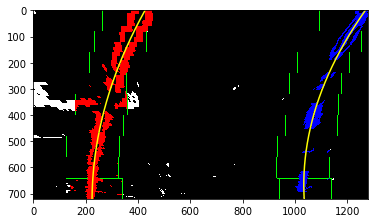

In [162]:
# Generate x and y values for plotting
%matplotlib auto
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imsave('./output_images/lane_linesjpg.jpg', out_img)

In [5]:
def sanity(binary_warped, line, base_pos, x_base_thresh, img_size, radius, leftx, lefty, rightx, righty, isLeft = True):
    global failures
    lane_detected = True
    midpointx = img_size[1]/2
    img_height = img_size[0]
    if (isLeft and (np.max(lefty) - np.min(lefty) < (img_height*0.5))):
        lane_detected = False
        print('Failed on left length')
        failures += 1
    if (isLeft == False and (np.max(righty) - np.min(righty) < (img_height*0.5))):
        lane_detected = False
        print('Failed on right length')
        failures += 1
    if (base_pos > line.line_base_pos + x_base_thresh or base_pos < line.line_base_pos - x_base_thresh):
        lane_detected = False
        print('Failed on line base')
        failures += 1
    if (radius < 2000 and line.radius_of_curvature < 2000):
        if ((radius > line.radius_of_curvature + 500) or (radius < line.radius_of_curvature - 5000)):
            lane_detected = False
            print('Failed on line radius, existing = ', line.radius_of_curvature, ' New: ', radius)
            failures += 1
    if (isLeft and base_pos > midpointx):
        lane_detected = False
        print('left base over half')
        failures += 1
    if (isLeft == False and base_pos < midpointx):
        lane_detected = False
        print('right base less than half')
        failures += 1
    if (lane_detected == False):
        plt.imsave('./failures/binary_warped' + str(failures) + '.jpg', binary_warped, cmap='gray')
        
    return lane_detected

In [6]:
def focused_search(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if (len(lefty) ==0):
        lefty = left_line.ally
    if (len(leftx) ==0):
        leftx = left_line.allx
    if (len(righty) ==0):
        righty = right_line.ally
    if (len(rightx) ==0):
        rightx = right_line.allx
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    return leftx, lefty, rightx, righty, left_fit, right_fit

In [7]:
def get_line_radius(ploty, x, y):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/810 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return curverad

In [8]:
def get_vehicle_position(img_shape, leftx_base, rightx_base):
    xm_per_pix = 3.7/810 # meters per pixel in x dimension
    img_center = img_shape[1]/2
    lane_center = (leftx_base + rightx_base)/2
    offset_px = img_center - lane_center
    offset_m = offset_px * xm_per_pix
    return offset_m
    #If offset_m is positive, then vehicle is to the right of center
    

In [9]:
from collections import deque
class Line(): 
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=15) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []

In [10]:
# Create an image to draw the lines on
def paint_lines(binary_warped, original_undist, ploty, left_fitx, right_fitx, avg_radius, lane_offset):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 100))
    font = cv2.FONT_HERSHEY_SIMPLEX
    side_of_center  = '{0:.2f}'.format(lane_offset) + 'm left of center'
    radius_value = '{0:.2f}'.format(avg_radius) + 'm'
    if (lane_offset > 0): 
        side_of_center = '{0:.2f}'.format(lane_offset) +  'm right of center'
    if (abs(lane_offset) < 0.005):
        side_of_center = 'centered'
    if (avg_radius > 5000):
        radius_value = 'Negligible'
    radius_string = 'Radius: ' + radius_value
    offset_string = 'Vehicle is ' + side_of_center
    cv2.putText(original_undist,radius_string,(750,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(original_undist,offset_string,(750,120), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_undist, 1, newwarp, 0.3, 0)
    
    return result

In [57]:
frame_count = 0
failures = 0
left_failures = 0
right_failures = 0
left_line = Line()
right_line = Line()

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


painted_lane_output = 'painted_new2.mp4'
clip1 = VideoFileClip('project_video.mp4')

yellow_clip = clip1.fl_image(process_image)
%time yellow_clip.write_videofile(painted_lane_output, audio=False)

First frame done
[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


  3%|██▏                                                                              | 13/485 [00:02<01:41,  4.65it/s]

Failed on line base


  3%|██▎                                                                              | 14/485 [00:03<01:46,  4.44it/s]

Failed on left length
Failed on line base


  3%|██▌                                                                              | 15/485 [00:03<01:48,  4.34it/s]

Failed on left length
Failed on line base


  3%|██▋                                                                              | 16/485 [00:03<02:01,  3.86it/s]

Failed on left length
Failed on line base


  4%|██▊                                                                              | 17/485 [00:03<01:59,  3.92it/s]

Failed on left length
Failed on line base


  4%|███▏                                                                             | 19/485 [00:04<01:49,  4.27it/s]

Failed on line radius, existing =  199.924697249  New:  846.023507254
Failed on line radius, existing =  650.21602264  New:  1348.09042355


  4%|███▎                                                                             | 20/485 [00:04<01:56,  3.99it/s]

Failed on left length


  4%|███▌                                                                             | 21/485 [00:04<01:54,  4.06it/s]

Failed on line radius, existing =  940.973113003  New:  1934.11546104


  5%|███▋                                                                             | 22/485 [00:05<02:02,  3.77it/s]

Failed on line base


  5%|████                                                                             | 24/485 [00:05<01:50,  4.15it/s]

Failed on line base
Failed on line radius, existing =  645.920963177  New:  1827.49558668


  5%|████▎                                                                            | 26/485 [00:06<01:49,  4.20it/s]

Failed on line radius, existing =  504.435008508  New:  1473.68645408


  6%|████▊                                                                            | 29/485 [00:06<01:42,  4.44it/s]

Failed on line base


  6%|█████▏                                                                           | 31/485 [00:07<01:51,  4.06it/s]

Failed on line radius, existing =  271.423086767  New:  835.025793549


  7%|█████▊                                                                           | 35/485 [00:08<01:31,  4.90it/s]

Failed on line base


  7%|██████                                                                           | 36/485 [00:08<01:36,  4.64it/s]

Failed on line radius, existing =  261.604245832  New:  1284.35750724


  8%|██████▎                                                                          | 38/485 [00:08<01:41,  4.39it/s]

Failed on line base


  8%|██████▌                                                                          | 39/485 [00:09<01:41,  4.39it/s]

Failed on line radius, existing =  395.270119926  New:  935.7507173


  8%|██████▋                                                                          | 40/485 [00:09<01:42,  4.34it/s]

Failed on line radius, existing =  395.270119926  New:  1246.19858826


  8%|██████▊                                                                          | 41/485 [00:09<01:43,  4.29it/s]

Failed on left length


  9%|███████                                                                          | 42/485 [00:09<01:44,  4.22it/s]

Failed on left length


  9%|███████▎                                                                         | 44/485 [00:10<01:36,  4.55it/s]

Failed on line base


  9%|███████▌                                                                         | 45/485 [00:10<01:41,  4.35it/s]

Failed on line radius, existing =  227.175116602  New:  1607.50269298


 10%|███████▊                                                                         | 47/485 [00:10<01:37,  4.51it/s]

Failed on line base


 10%|████████                                                                         | 48/485 [00:11<01:48,  4.01it/s]

Failed on line base


 10%|████████▎                                                                        | 50/485 [00:11<01:39,  4.39it/s]

Failed on line base


 11%|████████▌                                                                        | 51/485 [00:11<01:39,  4.38it/s]

Failed on line base


 11%|████████▋                                                                        | 52/485 [00:12<01:40,  4.33it/s]

Failed on left length


 11%|████████▊                                                                        | 53/485 [00:12<01:39,  4.32it/s]

Failed on line base


 11%|█████████                                                                        | 54/485 [00:12<01:42,  4.20it/s]

Failed on line base


 11%|█████████▏                                                                       | 55/485 [00:12<01:45,  4.08it/s]

Failed on line base


 12%|█████████▌                                                                       | 57/485 [00:13<01:37,  4.39it/s]

Failed on line base


 12%|█████████▋                                                                       | 58/485 [00:13<01:37,  4.39it/s]

Failed on line base


 12%|█████████▊                                                                       | 59/485 [00:13<01:38,  4.33it/s]

Failed on line base


 12%|██████████                                                                       | 60/485 [00:14<01:42,  4.13it/s]

Failed on line base


 13%|██████████▏                                                                      | 61/485 [00:14<01:41,  4.19it/s]

Failed on line base
Failed on right length


 13%|██████████▎                                                                      | 62/485 [00:14<01:49,  3.86it/s]

Failed on line base
Failed on line radius, existing =  188.617233028  New:  1621.87711499


 13%|██████████▌                                                                      | 63/485 [00:14<01:52,  3.73it/s]

Failed on line base


 13%|██████████▋                                                                      | 64/485 [00:15<02:00,  3.49it/s]

Failed on line base


 13%|██████████▊                                                                      | 65/485 [00:15<01:54,  3.66it/s]

Failed on line base
Failed on right length


 14%|███████████                                                                      | 66/485 [00:15<01:57,  3.56it/s]

Failed on line base


 14%|███████████▏                                                                     | 67/485 [00:15<01:51,  3.74it/s]

Failed on right length


 14%|███████████▎                                                                     | 68/485 [00:16<01:47,  3.89it/s]

Failed on left length
Failed on right length


 14%|███████████▌                                                                     | 69/485 [00:16<01:50,  3.78it/s]

Failed on line base
Failed on right length


 14%|███████████▋                                                                     | 70/485 [00:16<01:51,  3.72it/s]

Failed on left length
Failed on right length


 15%|███████████▊                                                                     | 71/485 [00:17<01:51,  3.70it/s]

Failed on left length
Failed on right length


 15%|████████████                                                                     | 72/485 [00:17<01:53,  3.64it/s]

Failed on left length
Failed on right length


 15%|████████████▏                                                                    | 73/485 [00:17<01:54,  3.58it/s]

Failed on line base
Failed on right length


 15%|████████████▎                                                                    | 74/485 [00:17<01:55,  3.57it/s]

Failed on line base
Failed on line radius, existing =  43.4762985628  New:  644.560264578


 15%|████████████▌                                                                    | 75/485 [00:18<01:48,  3.78it/s]

Failed on line base
left base over half


 16%|████████████▋                                                                    | 76/485 [00:18<01:42,  3.98it/s]

Failed on line base
left base over half


 16%|████████████▊                                                                    | 77/485 [00:18<01:39,  4.11it/s]

Failed on line base
left base over half


 16%|█████████████▏                                                                   | 79/485 [00:18<01:31,  4.46it/s]

Failed on line base


 16%|█████████████▎                                                                   | 80/485 [00:19<01:32,  4.36it/s]

Failed on line base
left base over half


 17%|█████████████▌                                                                   | 81/485 [00:19<01:35,  4.24it/s]

Failed on line base


 17%|█████████████▊                                                                   | 83/485 [00:19<01:29,  4.48it/s]

Failed on line base


 17%|██████████████                                                                   | 84/485 [00:20<01:43,  3.87it/s]

Failed on line base


 18%|██████████████▎                                                                  | 86/485 [00:20<01:31,  4.35it/s]

Failed on line base


 18%|██████████████▌                                                                  | 87/485 [00:20<01:32,  4.30it/s]

Failed on line base
left base over half


 18%|██████████████▋                                                                  | 88/485 [00:21<01:31,  4.32it/s]

Failed on line base
left base over half


 18%|██████████████▊                                                                  | 89/485 [00:21<01:31,  4.32it/s]

Failed on line base
left base over half


 19%|███████████████▌                                                                 | 93/485 [00:22<01:19,  4.91it/s]

Failed on line base


 19%|███████████████▋                                                                 | 94/485 [00:22<01:24,  4.61it/s]

Failed on line base


 20%|███████████████▊                                                                 | 95/485 [00:22<01:26,  4.49it/s]

Failed on line base
left base over half


 20%|████████████████                                                                 | 96/485 [00:22<01:28,  4.40it/s]

Failed on left length
Failed on line base


 20%|████████████████▏                                                                | 97/485 [00:23<01:34,  4.09it/s]

Failed on left length
Failed on line base
left base over half
Failed on line base


 20%|████████████████▎                                                                | 98/485 [00:23<01:49,  3.55it/s]

Failed on left length
Failed on line base
Failed on line base


 20%|████████████████▌                                                                | 99/485 [00:23<01:49,  3.52it/s]

Failed on left length
Failed on line base


 21%|████████████████▍                                                               | 100/485 [00:24<01:49,  3.51it/s]

Failed on left length
Failed on line base


 21%|████████████████▋                                                               | 101/485 [00:24<01:49,  3.51it/s]

Failed on left length
Failed on line base


 21%|████████████████▊                                                               | 102/485 [00:24<01:49,  3.51it/s]

Failed on left length
Failed on line base
Failed on line base
Failed on line radius, existing =  309.021885592  New:  969.999426999


 21%|████████████████▉                                                               | 103/485 [00:24<01:50,  3.47it/s]

Failed on left length
Failed on line base
Failed on line base


 21%|█████████████████▏                                                              | 104/485 [00:25<02:02,  3.11it/s]

Failed on left length
Failed on line base
Failed on line base


 22%|█████████████████▎                                                              | 105/485 [00:25<01:58,  3.21it/s]

Failed on left length
Failed on line base
Failed on line base


 22%|█████████████████▍                                                              | 106/485 [00:25<01:55,  3.28it/s]

Failed on left length
Failed on line base
Failed on line base


 22%|█████████████████▋                                                              | 107/485 [00:26<01:53,  3.32it/s]

Failed on left length
Failed on line base
Failed on line base


 22%|█████████████████▊                                                              | 108/485 [00:26<01:51,  3.38it/s]

Failed on left length
Failed on line base
Failed on line base


 22%|█████████████████▉                                                              | 109/485 [00:26<01:52,  3.33it/s]

Failed on left length
Failed on line base
Failed on line base


 23%|██████████████████▏                                                             | 110/485 [00:27<01:59,  3.13it/s]

Failed on left length
Failed on line base
Failed on line base


 23%|██████████████████▎                                                             | 111/485 [00:27<01:55,  3.23it/s]

Failed on left length
Failed on line base


 23%|██████████████████▍                                                             | 112/485 [00:27<01:52,  3.31it/s]

Failed on left length
Failed on line base


 23%|██████████████████▋                                                             | 113/485 [00:28<01:51,  3.33it/s]

Failed on left length
Failed on line base


 24%|██████████████████▊                                                             | 114/485 [00:28<01:50,  3.37it/s]

Failed on left length
Failed on line base


 24%|██████████████████▉                                                             | 115/485 [00:28<01:58,  3.14it/s]

Failed on left length
Failed on line base
Failed on line base


 24%|███████████████████▏                                                            | 116/485 [00:28<01:54,  3.23it/s]

Failed on left length
Failed on line base


 24%|███████████████████▎                                                            | 117/485 [00:29<01:51,  3.29it/s]

Failed on left length
Failed on line base


 24%|███████████████████▍                                                            | 118/485 [00:29<01:49,  3.35it/s]

Failed on left length
Failed on line base
Failed on line base
Failed on line radius, existing =  309.021885592  New:  828.107164964


 25%|███████████████████▋                                                            | 119/485 [00:29<01:48,  3.37it/s]

Failed on left length
Failed on line base


 25%|███████████████████▊                                                            | 120/485 [00:30<01:42,  3.58it/s]

Failed on left length
Failed on line base
Failed on line base
Failed on line radius, existing =  82.3788821845  New:  671.38643414


 25%|███████████████████▉                                                            | 121/485 [00:30<01:52,  3.23it/s]

Failed on left length
Failed on line base
Failed on line base


 25%|████████████████████                                                            | 122/485 [00:30<01:49,  3.30it/s]

Failed on left length
Failed on line base
Failed on line base
Failed on line radius, existing =  82.3788821845  New:  603.512479371


 25%|████████████████████▎                                                           | 123/485 [00:31<01:48,  3.34it/s]

Failed on left length
Failed on line base
Failed on line base


 26%|████████████████████▍                                                           | 124/485 [00:31<01:46,  3.39it/s]

Failed on left length
Failed on line base
Failed on right length
Failed on line base


 26%|████████████████████▌                                                           | 125/485 [00:31<01:45,  3.41it/s]

Failed on left length
Failed on line base
Failed on line base


 26%|████████████████████▊                                                           | 126/485 [00:31<01:44,  3.42it/s]

Failed on left length
Failed on line base
Failed on line base


 26%|████████████████████▉                                                           | 127/485 [00:32<01:52,  3.19it/s]

Failed on left length
Failed on line base
Failed on line base


 26%|█████████████████████                                                           | 128/485 [00:32<01:49,  3.27it/s]

Failed on left length
Failed on line base
Failed on line base


 27%|█████████████████████▎                                                          | 129/485 [00:32<01:47,  3.31it/s]

Failed on left length
Failed on line base
Failed on line base


 27%|█████████████████████▍                                                          | 130/485 [00:33<01:45,  3.37it/s]

Failed on left length
Failed on line base


 27%|█████████████████████▌                                                          | 131/485 [00:33<01:44,  3.39it/s]

Failed on line base


 27%|█████████████████████▊                                                          | 132/485 [00:33<01:37,  3.61it/s]

Failed on line base
Failed on line base


 27%|█████████████████████▉                                                          | 133/485 [00:33<01:37,  3.60it/s]

Failed on line base
Failed on line base


 28%|██████████████████████                                                          | 134/485 [00:34<01:38,  3.58it/s]

Failed on line base
Failed on line base


 28%|██████████████████████▎                                                         | 135/485 [00:34<01:46,  3.29it/s]

Failed on line base


 28%|██████████████████████▍                                                         | 136/485 [00:34<01:38,  3.54it/s]

Failed on line base
Failed on line radius, existing =  189.73506652  New:  1857.37116107
Failed on line base
right base less than half


 28%|██████████████████████▌                                                         | 137/485 [00:35<01:39,  3.51it/s]

Failed on line base
Failed on right length


 28%|██████████████████████▊                                                         | 138/485 [00:35<01:39,  3.47it/s]

Failed on line base
Failed on line base
right base less than half


 29%|██████████████████████▉                                                         | 139/485 [00:35<01:39,  3.48it/s]

Failed on line base
right base less than half


 29%|███████████████████████                                                         | 140/485 [00:35<01:34,  3.64it/s]

Failed on line base


 29%|███████████████████████▎                                                        | 141/485 [00:36<01:31,  3.75it/s]

Failed on line base
Failed on line base


 29%|███████████████████████▍                                                        | 142/485 [00:36<01:43,  3.32it/s]

Failed on line base
left base over half
Failed on line base


 29%|███████████████████████▌                                                        | 143/485 [00:36<01:42,  3.34it/s]

Failed on line base
left base over half
Failed on line base


 30%|███████████████████████▊                                                        | 144/485 [00:37<01:42,  3.34it/s]

Failed on line base
left base over half
Failed on line base


 30%|███████████████████████▉                                                        | 145/485 [00:37<01:41,  3.35it/s]

Failed on line base
left base over half
Failed on line base


 30%|████████████████████████                                                        | 146/485 [00:37<01:40,  3.36it/s]

Failed on line base
left base over half
Failed on line base


 30%|████████████████████████▏                                                       | 147/485 [00:38<01:40,  3.38it/s]

Failed on line base
left base over half
Failed on line base


 31%|████████████████████████▍                                                       | 148/485 [00:38<01:47,  3.13it/s]

Failed on line base
left base over half
Failed on line base


 31%|████████████████████████▌                                                       | 149/485 [00:38<01:45,  3.20it/s]

Failed on line base
Failed on line base


 31%|████████████████████████▋                                                       | 150/485 [00:39<01:43,  3.25it/s]

Failed on line base
Failed on line base


 31%|████████████████████████▉                                                       | 151/485 [00:39<01:41,  3.28it/s]

Failed on line base
Failed on line base


 31%|█████████████████████████                                                       | 152/485 [00:39<01:40,  3.33it/s]

Failed on line base
Failed on line base


 32%|█████████████████████████▏                                                      | 153/485 [00:40<01:48,  3.06it/s]

Failed on line base
Failed on line base


 32%|█████████████████████████▍                                                      | 154/485 [00:40<01:45,  3.15it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  940.413383402


 32%|█████████████████████████▌                                                      | 155/485 [00:40<01:43,  3.20it/s]

Failed on line base
Failed on line base


 32%|█████████████████████████▋                                                      | 156/485 [00:40<01:40,  3.26it/s]

Failed on line base
Failed on line base


 32%|█████████████████████████▉                                                      | 157/485 [00:41<01:39,  3.29it/s]

Failed on line base


 33%|██████████████████████████                                                      | 158/485 [00:41<01:33,  3.48it/s]

Failed on line base


 33%|██████████████████████████▏                                                     | 159/485 [00:41<01:38,  3.32it/s]

Failed on right length
Failed on line base


 33%|██████████████████████████▍                                                     | 160/485 [00:42<01:33,  3.48it/s]

Failed on line base


 33%|██████████████████████████▌                                                     | 161/485 [00:42<01:29,  3.63it/s]

Failed on line base


 33%|██████████████████████████▋                                                     | 162/485 [00:42<01:26,  3.73it/s]

Failed on line base


 34%|██████████████████████████▉                                                     | 163/485 [00:42<01:32,  3.48it/s]

Failed on line base


 34%|███████████████████████████                                                     | 164/485 [00:43<01:29,  3.60it/s]

Failed on line base


 34%|███████████████████████████▏                                                    | 165/485 [00:43<01:26,  3.70it/s]

Failed on line base
Failed on line base


 34%|███████████████████████████▍                                                    | 166/485 [00:43<01:29,  3.58it/s]

Failed on line base
Failed on line base


 34%|███████████████████████████▌                                                    | 167/485 [00:43<01:30,  3.50it/s]

Failed on line base
Failed on line base


 35%|███████████████████████████▋                                                    | 168/485 [00:44<01:38,  3.21it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  590.603139908


 35%|███████████████████████████▉                                                    | 169/485 [00:44<01:38,  3.22it/s]

Failed on line base
Failed on line base


 35%|████████████████████████████                                                    | 170/485 [00:44<01:36,  3.26it/s]

Failed on line base
Failed on line base


 35%|████████████████████████████▏                                                   | 171/485 [00:45<01:35,  3.30it/s]

Failed on line base
Failed on line base


 35%|████████████████████████████▎                                                   | 172/485 [00:45<01:41,  3.07it/s]

Failed on line base
Failed on line base


 36%|████████████████████████████▌                                                   | 173/485 [00:45<01:38,  3.16it/s]

Failed on line base
Failed on line base


 36%|████████████████████████████▋                                                   | 174/485 [00:46<01:36,  3.23it/s]

Failed on line base
Failed on line base


 36%|████████████████████████████▊                                                   | 175/485 [00:46<01:34,  3.27it/s]

Failed on line base
Failed on line base


 36%|█████████████████████████████                                                   | 176/485 [00:46<01:33,  3.31it/s]

Failed on line base
Failed on line base


 36%|█████████████████████████████▏                                                  | 177/485 [00:47<01:40,  3.06it/s]

Failed on line base
Failed on line base


 37%|█████████████████████████████▎                                                  | 178/485 [00:47<01:37,  3.15it/s]

Failed on line base
Failed on line base


 37%|█████████████████████████████▌                                                  | 179/485 [00:47<01:35,  3.21it/s]

Failed on line base
Failed on line base


 37%|█████████████████████████████▋                                                  | 180/485 [00:48<01:34,  3.24it/s]

Failed on line base
Failed on line base


 37%|█████████████████████████████▊                                                  | 181/485 [00:48<01:39,  3.05it/s]

Failed on line base
Failed on line base


 38%|██████████████████████████████                                                  | 182/485 [00:48<01:36,  3.13it/s]

Failed on line base
Failed on line base


 38%|██████████████████████████████▏                                                 | 183/485 [00:49<01:34,  3.20it/s]

Failed on line base
Failed on line base


 38%|██████████████████████████████▎                                                 | 184/485 [00:49<01:33,  3.23it/s]

Failed on line base
Failed on line base


 38%|██████████████████████████████▌                                                 | 185/485 [00:49<01:39,  3.00it/s]

Failed on line base
Failed on line base


 38%|██████████████████████████████▋                                                 | 186/485 [00:50<01:36,  3.10it/s]

Failed on line base
Failed on line base


 39%|██████████████████████████████▊                                                 | 187/485 [00:50<01:34,  3.17it/s]

Failed on line base
Failed on line base


 39%|███████████████████████████████                                                 | 188/485 [00:50<01:31,  3.23it/s]

Failed on line base


 39%|███████████████████████████████▏                                                | 189/485 [00:50<01:26,  3.41it/s]

Failed on line base
Failed on line base


 39%|███████████████████████████████▎                                                | 190/485 [00:51<01:32,  3.18it/s]

Failed on line base
Failed on line base


 39%|███████████████████████████████▌                                                | 191/485 [00:51<01:29,  3.27it/s]

Failed on line base
left base over half
Failed on line base


 40%|███████████████████████████████▋                                                | 192/485 [00:51<01:28,  3.32it/s]

Failed on line base
Failed on line base


 40%|███████████████████████████████▊                                                | 193/485 [00:52<01:26,  3.37it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1996.88292419


 40%|████████████████████████████████                                                | 194/485 [00:52<01:26,  3.37it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  795.190418271


 40%|████████████████████████████████▏                                               | 195/485 [00:52<01:21,  3.54it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  637.746959517


 40%|████████████████████████████████▎                                               | 196/485 [00:52<01:22,  3.50it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  725.086020014


 41%|████████████████████████████████▍                                               | 197/485 [00:53<01:23,  3.46it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  668.331778392


 41%|████████████████████████████████▋                                               | 198/485 [00:53<01:19,  3.60it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  728.181499265


 41%|████████████████████████████████▊                                               | 199/485 [00:53<01:28,  3.23it/s]

Failed on line base
Failed on line base


 41%|████████████████████████████████▉                                               | 200/485 [00:54<01:27,  3.27it/s]

Failed on line base
Failed on line base


 41%|█████████████████████████████████▏                                              | 201/485 [00:54<01:25,  3.32it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  738.237501307


 42%|█████████████████████████████████▎                                              | 202/485 [00:54<01:24,  3.35it/s]

Failed on line base
Failed on line base


 42%|█████████████████████████████████▍                                              | 203/485 [00:55<01:23,  3.38it/s]

Failed on line base
Failed on line base


 42%|█████████████████████████████████▋                                              | 204/485 [00:55<01:22,  3.42it/s]

Failed on left length
Failed on line base
Failed on line base


 42%|█████████████████████████████████▊                                              | 205/485 [00:55<01:21,  3.44it/s]

Failed on left length
Failed on line base


 42%|█████████████████████████████████▉                                              | 206/485 [00:55<01:20,  3.45it/s]

Failed on line base
Failed on line base


 43%|██████████████████████████████████▏                                             | 207/485 [00:56<01:26,  3.21it/s]

Failed on line base


 43%|██████████████████████████████████▎                                             | 208/485 [00:56<01:20,  3.44it/s]

Failed on left length
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  712.105706949


 43%|██████████████████████████████████▍                                             | 209/485 [00:56<01:20,  3.45it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  649.051702974


 43%|██████████████████████████████████▋                                             | 210/485 [00:57<01:15,  3.62it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1035.45611649


 44%|██████████████████████████████████▊                                             | 211/485 [00:57<01:16,  3.56it/s]

Failed on line base


 44%|██████████████████████████████████▉                                             | 212/485 [00:57<01:13,  3.73it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1176.26903914


 44%|███████████████████████████████████▏                                            | 213/485 [00:57<01:10,  3.85it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  750.49395178


 44%|███████████████████████████████████▎                                            | 214/485 [00:58<01:08,  3.93it/s]

Failed on line base


 44%|███████████████████████████████████▍                                            | 215/485 [00:58<01:13,  3.67it/s]

Failed on line base


 45%|███████████████████████████████████▋                                            | 216/485 [00:58<01:10,  3.83it/s]

Failed on line base


 45%|███████████████████████████████████▊                                            | 217/485 [00:58<01:07,  3.95it/s]

Failed on line base


 45%|███████████████████████████████████▉                                            | 218/485 [00:59<01:06,  4.00it/s]

Failed on left length
Failed on line base
left base over half
Failed on line base


 45%|████████████████████████████████████                                            | 219/485 [00:59<01:09,  3.84it/s]

Failed on line base
Failed on line base


 45%|████████████████████████████████████▎                                           | 220/485 [00:59<01:11,  3.73it/s]

Failed on line base


 46%|████████████████████████████████████▍                                           | 221/485 [00:59<01:08,  3.88it/s]

Failed on line base
left base over half
Failed on line base


 46%|████████████████████████████████████▌                                           | 222/485 [01:00<01:10,  3.75it/s]

Failed on line base
Failed on line base


 46%|████████████████████████████████████▊                                           | 223/485 [01:00<01:11,  3.67it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  621.884045787


 46%|████████████████████████████████████▉                                           | 224/485 [01:00<01:19,  3.30it/s]

Failed on line base
Failed on line base


 46%|█████████████████████████████████████                                           | 225/485 [01:01<01:17,  3.35it/s]

Failed on line base
Failed on line base


 47%|█████████████████████████████████████▎                                          | 226/485 [01:01<01:16,  3.38it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1957.08285867


 47%|█████████████████████████████████████▍                                          | 227/485 [01:01<01:12,  3.58it/s]

Failed on line base
Failed on line radius, existing =  51.411769646  New:  660.158211254
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  730.859230923


 47%|█████████████████████████████████████▌                                          | 228/485 [01:01<01:13,  3.52it/s]

Failed on line base
Failed on line base


 47%|█████████████████████████████████████▊                                          | 229/485 [01:02<01:12,  3.51it/s]

Failed on line base
Failed on line base


 47%|█████████████████████████████████████▉                                          | 230/485 [01:02<01:12,  3.50it/s]

Failed on line base
Failed on line base


 48%|██████████████████████████████████████                                          | 231/485 [01:02<01:12,  3.50it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  898.188516306


 48%|██████████████████████████████████████▎                                         | 232/485 [01:03<01:12,  3.47it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  944.441018532


 48%|██████████████████████████████████████▍                                         | 233/485 [01:03<01:15,  3.35it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  611.400967517


 48%|██████████████████████████████████████▌                                         | 234/485 [01:03<01:15,  3.34it/s]

Failed on line base
Failed on line base


 48%|██████████████████████████████████████▊                                         | 235/485 [01:04<01:13,  3.39it/s]

Failed on line base
Failed on line base


 49%|██████████████████████████████████████▉                                         | 236/485 [01:04<01:12,  3.42it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1010.32936488


 49%|███████████████████████████████████████                                         | 237/485 [01:04<01:09,  3.59it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1095.76884803


 49%|███████████████████████████████████████▎                                        | 238/485 [01:04<01:06,  3.72it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  640.903164584


 49%|███████████████████████████████████████▍                                        | 239/485 [01:05<01:07,  3.64it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  857.561615467


 49%|███████████████████████████████████████▌                                        | 240/485 [01:05<01:08,  3.56it/s]

Failed on line base
Failed on line base


 50%|███████████████████████████████████████▊                                        | 241/485 [01:05<01:09,  3.50it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  721.658991672


 50%|███████████████████████████████████████▉                                        | 242/485 [01:06<01:15,  3.21it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1209.1376326


 50%|████████████████████████████████████████                                        | 243/485 [01:06<01:14,  3.25it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  958.300613795


 50%|████████████████████████████████████████▏                                       | 244/485 [01:06<01:09,  3.47it/s]

Failed on line base
Failed on line base


 51%|████████████████████████████████████████▍                                       | 245/485 [01:06<01:09,  3.48it/s]

Failed on line base
Failed on line base


 51%|████████████████████████████████████████▌                                       | 246/485 [01:07<01:08,  3.50it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1016.78054678


 51%|████████████████████████████████████████▋                                       | 247/485 [01:07<01:08,  3.47it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  706.108498118


 51%|████████████████████████████████████████▉                                       | 248/485 [01:07<01:08,  3.47it/s]

Failed on line radius, existing =  81.6178647721  New:  710.06820505
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  870.578633685


 51%|█████████████████████████████████████████                                       | 249/485 [01:08<01:08,  3.43it/s]

Failed on line base
Failed on line base


 52%|█████████████████████████████████████████▏                                      | 250/485 [01:08<01:13,  3.19it/s]

Failed on line base
Failed on line radius, existing =  81.6178647721  New:  1382.21314463
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  877.342454324


 52%|█████████████████████████████████████████▍                                      | 251/485 [01:08<01:12,  3.23it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  964.951223064


 52%|█████████████████████████████████████████▌                                      | 252/485 [01:08<01:10,  3.28it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1199.27532887


 52%|█████████████████████████████████████████▋                                      | 253/485 [01:09<01:10,  3.31it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1529.46021922


 52%|█████████████████████████████████████████▉                                      | 254/485 [01:09<01:09,  3.34it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1939.69362996


 53%|██████████████████████████████████████████                                      | 255/485 [01:09<01:04,  3.54it/s]

Failed on line base
Failed on line base


 53%|██████████████████████████████████████████▏                                     | 256/485 [01:10<01:04,  3.52it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  800.981455343


 53%|██████████████████████████████████████████▍                                     | 257/485 [01:10<01:10,  3.21it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  734.080365885


 53%|██████████████████████████████████████████▌                                     | 258/485 [01:10<01:10,  3.21it/s]

Failed on line base
Failed on line radius, existing =  89.2966185428  New:  666.052250419


 53%|██████████████████████████████████████████▋                                     | 259/485 [01:11<01:05,  3.43it/s]

Failed on left length
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  738.081624883


 54%|██████████████████████████████████████████▉                                     | 260/485 [01:11<01:05,  3.44it/s]

Failed on line base
Failed on line base


 54%|███████████████████████████████████████████                                     | 261/485 [01:11<01:04,  3.45it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1176.4285199


 54%|███████████████████████████████████████████▏                                    | 262/485 [01:11<01:04,  3.44it/s]

Failed on line base
Failed on line radius, existing =  58.0416453837  New:  711.214365802
Failed on line base


 54%|███████████████████████████████████████████▍                                    | 263/485 [01:12<01:04,  3.44it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1160.25944003


 54%|███████████████████████████████████████████▌                                    | 264/485 [01:12<01:04,  3.45it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  820.388053272


 55%|███████████████████████████████████████████▋                                    | 265/485 [01:12<01:04,  3.44it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1419.81054069


 55%|███████████████████████████████████████████▉                                    | 266/485 [01:13<01:08,  3.18it/s]

Failed on line base
Failed on line base


 55%|████████████████████████████████████████████                                    | 267/485 [01:13<01:07,  3.25it/s]

Failed on line base
Failed on line base


 55%|████████████████████████████████████████████▏                                   | 268/485 [01:13<01:05,  3.31it/s]

Failed on line base
Failed on line base


 55%|████████████████████████████████████████████▎                                   | 269/485 [01:14<01:04,  3.35it/s]

Failed on line base
Failed on line base


 56%|████████████████████████████████████████████▌                                   | 270/485 [01:14<01:02,  3.41it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1038.07575785


 56%|████████████████████████████████████████████▋                                   | 271/485 [01:14<01:02,  3.43it/s]

Failed on line radius, existing =  58.0416453837  New:  910.950522264
Failed on line base


 56%|████████████████████████████████████████████▊                                   | 272/485 [01:14<01:02,  3.43it/s]

Failed on line base


 56%|█████████████████████████████████████████████                                   | 273/485 [01:15<00:58,  3.64it/s]

Failed on line base
Failed on line base


 56%|█████████████████████████████████████████████▏                                  | 274/485 [01:15<00:58,  3.62it/s]

Failed on line base
Failed on line base


 57%|█████████████████████████████████████████████▎                                  | 275/485 [01:15<01:03,  3.29it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1149.50772519


 57%|█████████████████████████████████████████████▌                                  | 276/485 [01:16<01:02,  3.34it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  616.078798992


 57%|█████████████████████████████████████████████▋                                  | 277/485 [01:16<01:02,  3.35it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  803.541311859


 57%|█████████████████████████████████████████████▊                                  | 278/485 [01:16<01:01,  3.37it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1566.02589483


 58%|██████████████████████████████████████████████                                  | 279/485 [01:16<01:01,  3.36it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1378.09658445


 58%|██████████████████████████████████████████████▏                                 | 280/485 [01:17<01:00,  3.38it/s]

Failed on line base
Failed on line base


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:17<00:59,  3.41it/s]

Failed on line base


 58%|██████████████████████████████████████████████▌                                 | 282/485 [01:17<00:56,  3.61it/s]

Failed on line base
Failed on line radius, existing =  879.135531123  New:  1901.88021899
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  1342.05509388


 58%|██████████████████████████████████████████████▋                                 | 283/485 [01:18<00:57,  3.52it/s]

Failed on line base
left base over half
Failed on line base


 59%|██████████████████████████████████████████████▊                                 | 284/485 [01:18<01:02,  3.24it/s]

Failed on line base
Failed on line base


 59%|███████████████████████████████████████████████                                 | 285/485 [01:18<01:01,  3.25it/s]

Failed on line base
left base over half
Failed on line base


 59%|███████████████████████████████████████████████▏                                | 286/485 [01:19<01:00,  3.28it/s]

Failed on line base
left base over half
Failed on line base


 59%|███████████████████████████████████████████████▎                                | 287/485 [01:19<00:59,  3.31it/s]

Failed on line base
Failed on line base


 59%|███████████████████████████████████████████████▌                                | 288/485 [01:19<00:58,  3.34it/s]

Failed on line base


 60%|███████████████████████████████████████████████▋                                | 289/485 [01:19<00:55,  3.53it/s]

Failed on line base
Failed on line base


 60%|███████████████████████████████████████████████▊                                | 290/485 [01:20<00:56,  3.48it/s]

Failed on line base


 60%|████████████████████████████████████████████████                                | 291/485 [01:20<00:53,  3.66it/s]

Failed on line radius, existing =  66.4371839244  New:  1452.7012301
Failed on line base


 60%|████████████████████████████████████████████████▏                               | 292/485 [01:20<00:58,  3.30it/s]

Failed on line base
Failed on line base


 60%|████████████████████████████████████████████████▎                               | 293/485 [01:21<00:57,  3.35it/s]

Failed on line base
left base over half
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  754.643205175


 61%|████████████████████████████████████████████████▍                               | 294/485 [01:21<00:56,  3.36it/s]

Failed on line base
left base over half
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  659.540606925


 61%|████████████████████████████████████████████████▋                               | 295/485 [01:21<00:56,  3.38it/s]

Failed on line base


 61%|████████████████████████████████████████████████▊                               | 296/485 [01:21<00:52,  3.58it/s]

Failed on line base
left base over half
Failed on line base


 61%|████████████████████████████████████████████████▉                               | 297/485 [01:22<00:53,  3.54it/s]

Failed on line base
left base over half
Failed on line base


 61%|█████████████████████████████████████████████████▏                              | 298/485 [01:22<00:53,  3.47it/s]

Failed on line base
Failed on line base


 62%|█████████████████████████████████████████████████▎                              | 299/485 [01:22<00:53,  3.47it/s]

Failed on line base


 62%|█████████████████████████████████████████████████▍                              | 300/485 [01:23<00:50,  3.64it/s]

Failed on line base


 62%|█████████████████████████████████████████████████▋                              | 301/485 [01:23<00:53,  3.45it/s]

Failed on line base
Failed on line base


 62%|█████████████████████████████████████████████████▊                              | 302/485 [01:23<00:53,  3.42it/s]

Failed on line base
Failed on line base


 62%|█████████████████████████████████████████████████▉                              | 303/485 [01:23<00:53,  3.43it/s]

Failed on line base
Failed on right length
Failed on line base


 63%|██████████████████████████████████████████████████▏                             | 304/485 [01:24<00:52,  3.44it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  835.447722313


 63%|██████████████████████████████████████████████████▎                             | 305/485 [01:24<00:53,  3.36it/s]

Failed on line base


 63%|██████████████████████████████████████████████████▍                             | 306/485 [01:24<00:50,  3.54it/s]

Failed on line base
left base over half
Failed on line base


 63%|██████████████████████████████████████████████████▋                             | 307/485 [01:25<00:50,  3.52it/s]

Failed on line base
left base over half
Failed on line base
Failed on line radius, existing =  89.2966185428  New:  792.625977876


 64%|██████████████████████████████████████████████████▊                             | 308/485 [01:25<00:51,  3.45it/s]

Failed on line base
Failed on line base


 64%|██████████████████████████████████████████████████▉                             | 309/485 [01:25<00:55,  3.17it/s]

Failed on line base


 64%|███████████████████████████████████████████████████▏                            | 310/485 [01:25<00:51,  3.41it/s]

Failed on line base


 64%|███████████████████████████████████████████████████▎                            | 311/485 [01:26<00:48,  3.58it/s]

Failed on line base
Failed on line base


 64%|███████████████████████████████████████████████████▍                            | 312/485 [01:26<00:48,  3.54it/s]

Failed on line base


 65%|███████████████████████████████████████████████████▋                            | 313/485 [01:26<00:46,  3.68it/s]

Failed on line base
Failed on line base


 65%|███████████████████████████████████████████████████▊                            | 314/485 [01:27<00:47,  3.59it/s]

Failed on line base


 65%|███████████████████████████████████████████████████▉                            | 315/485 [01:27<00:50,  3.40it/s]

Failed on line base
Failed on line base


 65%|████████████████████████████████████████████████████                            | 316/485 [01:27<00:49,  3.41it/s]

Failed on line base
Failed on right length
Failed on line base


 65%|████████████████████████████████████████████████████▎                           | 317/485 [01:28<00:49,  3.37it/s]

Failed on line base
Failed on line base


 66%|████████████████████████████████████████████████████▍                           | 318/485 [01:28<00:49,  3.37it/s]

Failed on line base


 66%|████████████████████████████████████████████████████▌                           | 319/485 [01:28<00:47,  3.52it/s]

Failed on line base
Failed on line base


 66%|████████████████████████████████████████████████████▊                           | 320/485 [01:28<00:51,  3.19it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  583.256516986


 66%|████████████████████████████████████████████████████▉                           | 321/485 [01:29<00:50,  3.23it/s]

Failed on line base
Failed on line base


 66%|█████████████████████████████████████████████████████                           | 322/485 [01:29<00:49,  3.28it/s]

Failed on line base
Failed on line radius, existing =  155.549909237  New:  772.525418255
Failed on line base


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [01:29<00:49,  3.30it/s]

Failed on line base
Failed on line base


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [01:30<00:52,  3.08it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1360.65920679


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [01:30<00:50,  3.16it/s]

Failed on line base
Failed on line base


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [01:30<00:49,  3.22it/s]

Failed on line base
Failed on line base


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [01:31<00:48,  3.27it/s]

Failed on line base
Failed on line radius, existing =  155.549909237  New:  1360.07096811
Failed on line base


 68%|██████████████████████████████████████████████████████                          | 328/485 [01:31<00:51,  3.04it/s]

Failed on line base
Failed on line radius, existing =  155.549909237  New:  722.881301907
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1019.2244136


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [01:31<00:50,  3.10it/s]

Failed on line base
Failed on line base


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [01:32<00:48,  3.18it/s]

Failed on line base


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [01:32<00:45,  3.38it/s]

Failed on line base


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [01:32<00:43,  3.51it/s]

Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1796.84800399


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [01:32<00:45,  3.32it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1514.61532919


 69%|███████████████████████████████████████████████████████                         | 334/485 [01:33<00:45,  3.31it/s]

Failed on line base
left base over half
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1710.48186169


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [01:33<00:45,  3.29it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  708.779711611


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [01:33<00:49,  3.01it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  941.074554503
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  732.824702033


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [01:34<00:48,  3.02it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1055.22619489
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  998.406358536


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [01:34<00:47,  3.07it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1102.4018108
Failed on line base


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [01:34<00:50,  2.91it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1236.18923254
Failed on line base


 70%|████████████████████████████████████████████████████████                        | 340/485 [01:35<00:48,  2.98it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1490.86682264
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1060.2679087


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [01:35<00:47,  3.04it/s]

Failed on line base
left base over half
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  978.006266076


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [01:35<00:45,  3.11it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1275.83375032
Failed on line base


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [01:36<00:48,  2.90it/s]

Failed on line base
Failed on line radius, existing =  319.947495684  New:  1652.77729458
Failed on line base


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [01:36<00:46,  3.00it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  793.673183138


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [01:36<00:45,  3.08it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  743.089980721


 71%|█████████████████████████████████████████████████████████                       | 346/485 [01:37<00:47,  2.92it/s]

Failed on line base
Failed on line base


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [01:37<00:46,  2.99it/s]

Failed on line base


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [01:37<00:42,  3.20it/s]

Failed on line base


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [01:38<00:43,  3.13it/s]

Failed on line base
Failed on line base


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [01:38<00:42,  3.16it/s]

Failed on line base
Failed on line base


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [01:38<00:42,  3.18it/s]

Failed on line base
Failed on line base


 73%|██████████████████████████████████████████████████████████                      | 352/485 [01:39<00:42,  3.15it/s]

Failed on line base
Failed on line base
right base less than half


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [01:39<00:44,  2.97it/s]

Failed on line base
Failed on line base


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [01:39<00:42,  3.05it/s]

Failed on line base
Failed on line base


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [01:40<00:44,  2.91it/s]

Failed on line base
left base over half
Failed on line base


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [01:40<00:42,  3.01it/s]

Failed on line base
Failed on line radius, existing =  70.7677274582  New:  933.527520804


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [01:40<00:39,  3.22it/s]

Failed on line base
Failed on line base


 74%|███████████████████████████████████████████████████████████                     | 358/485 [01:41<00:42,  2.97it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1065.71484835


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [01:41<00:41,  3.04it/s]

Failed on line base
Failed on line base


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [01:41<00:40,  3.12it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  934.072850919


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [01:42<00:39,  3.16it/s]

Failed on line base
Failed on line base


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [01:42<00:41,  2.97it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1932.47204279
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  641.642117088


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [01:42<00:40,  3.05it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1507.91833706
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1238.42963182


 75%|████████████████████████████████████████████████████████████                    | 364/485 [01:43<00:39,  3.06it/s]

Failed on line base
Failed on line base


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [01:43<00:41,  2.90it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1119.53891974
Failed on line base


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [01:43<00:39,  2.99it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1160.12197524
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  717.370682031


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [01:44<00:39,  3.02it/s]

Failed on line base
Failed on line base


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [01:44<00:40,  2.88it/s]

Failed on line base
Failed on line base


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [01:44<00:38,  2.98it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1318.82029152
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  584.599858776


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [01:45<00:40,  2.83it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1449.3351503
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  639.533373336


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [01:45<00:38,  2.94it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1411.35080539
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  695.467286872


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [01:45<00:37,  3.01it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1465.30799814
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  687.022263759


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [01:46<00:39,  2.83it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1261.39446532
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  692.368366632


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [01:46<00:38,  2.91it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1581.11143281
Failed on right length
Failed on line base


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [01:46<00:36,  3.00it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1555.52607138
Failed on line base


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [01:47<00:38,  2.82it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1813.00882982
Failed on line base


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [01:47<00:36,  2.94it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1262.88799353
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  942.097308305


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [01:47<00:35,  3.02it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1414.12412096
Failed on right length
Failed on line base


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [01:48<00:36,  2.88it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1382.40560943
Failed on line base


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [01:48<00:35,  2.97it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1840.4172811
Failed on line base


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [01:48<00:34,  3.05it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1608.256701
Failed on line base


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [01:49<00:35,  2.89it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1147.0311612
Failed on line base


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [01:49<00:34,  2.99it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1737.45583291
Failed on line base


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [01:49<00:32,  3.06it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1143.33305028
Failed on line base


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [01:50<00:32,  3.12it/s]

Failed on line base
Failed on line base


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [01:50<00:31,  3.16it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1472.37832127
Failed on line base


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [01:50<00:33,  2.94it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1117.05211394
Failed on line base


 80%|████████████████████████████████████████████████████████████████                | 388/485 [01:51<00:32,  3.02it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1418.14819166
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1167.7055525


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [01:51<00:31,  3.06it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1816.97985023
Failed on right length
Failed on line base


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [01:51<00:30,  3.10it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1714.57547418
Failed on line base


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [01:52<00:32,  2.91it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1025.557942
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1266.28655743


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [01:52<00:31,  2.97it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1042.14169212
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  993.655902624


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [01:52<00:30,  3.01it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1073.86657237
Failed on line base


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [01:53<00:29,  3.06it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1556.86906306


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [01:53<00:31,  2.87it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  946.813091942
Failed on line base


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [01:53<00:30,  2.95it/s]

Failed on line base
Failed on line base


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [01:54<00:29,  3.03it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  915.364341271
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1407.49073739


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [01:54<00:28,  3.03it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1988.79023648


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [01:54<00:29,  2.88it/s]

Failed on line base
Failed on line base


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [01:55<00:28,  2.98it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1993.45742406


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [01:55<00:27,  3.04it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1956.18083937


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [01:55<00:28,  2.89it/s]

Failed on line base
Failed on line base


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [01:56<00:27,  3.00it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1375.24782984


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [01:56<00:26,  3.05it/s]

Failed on line base
Failed on line base


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [01:56<00:27,  2.90it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1584.87045664


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [01:57<00:26,  2.99it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1487.19270663


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [01:57<00:25,  3.05it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1812.83325468


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [01:57<00:26,  2.88it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  648.648615891


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [01:58<00:25,  2.97it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  868.017634576


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [01:58<00:24,  3.04it/s]

Failed on line base
Failed on line base


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [01:58<00:25,  2.90it/s]

Failed on line base
Failed on line base


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [01:59<00:24,  3.00it/s]

Failed on line base
Failed on line base


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [01:59<00:23,  3.08it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1417.74463864


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [01:59<00:24,  2.88it/s]

Failed on line base
Failed on line radius, existing =  346.819986353  New:  1132.20738544
Failed on line base


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [02:00<00:23,  2.97it/s]

Failed on line base
Failed on line base


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [02:00<00:24,  2.85it/s]

Failed on line base
Failed on line base


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [02:00<00:23,  2.95it/s]

Failed on line base
Failed on line base


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [02:01<00:22,  3.04it/s]

Failed on line base


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [02:01<00:20,  3.23it/s]

Failed on line base
Failed on line base


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [02:01<00:21,  3.00it/s]

Failed on line base
Failed on line base


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [02:02<00:20,  3.07it/s]

Failed on line base
Failed on line base


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [02:02<00:20,  3.12it/s]

Failed on line base
Failed on line base


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [02:02<00:20,  2.95it/s]

Failed on line base
Failed on line base


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [02:03<00:20,  3.02it/s]

Failed on line base
Failed on line base


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [02:03<00:19,  3.04it/s]

Failed on line base
Failed on line radius, existing =  244.679232868  New:  1819.34714584
Failed on line base


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [02:03<00:20,  2.88it/s]

Failed on line base
Failed on line radius, existing =  70.7677274582  New:  790.51501382


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [02:04<00:18,  3.10it/s]

Failed on line base
Failed on line base


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [02:04<00:18,  3.14it/s]

Failed on line base


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [02:04<00:18,  3.09it/s]

Failed on line base


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [02:05<00:16,  3.30it/s]

Failed on line base
Failed on line base


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [02:05<00:16,  3.31it/s]

Failed on line base
Failed on line base


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [02:05<00:16,  3.31it/s]

Failed on line base
Failed on line base


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [02:06<00:17,  3.04it/s]

Failed on line base
Failed on line base


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [02:06<00:16,  3.10it/s]

Failed on line base
Failed on line base


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [02:06<00:15,  3.17it/s]

Failed on line base
Failed on line base


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [02:07<00:16,  2.97it/s]

Failed on line base
Failed on line base


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [02:07<00:15,  3.07it/s]

Failed on line base
Failed on line base


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [02:07<00:14,  3.14it/s]

Failed on line base
Failed on line base


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [02:08<00:14,  3.19it/s]

Failed on line base
Failed on line base


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [02:08<00:15,  3.00it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  761.466284898


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [02:08<00:14,  3.07it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  613.680644836


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [02:09<00:13,  3.13it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  888.549390053


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [02:09<00:13,  3.15it/s]

Failed on line base
Failed on line base


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [02:09<00:13,  2.98it/s]

Failed on line base
Failed on line base


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [02:10<00:13,  3.07it/s]

Failed on line base
Failed on line base


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [02:10<00:12,  3.16it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1422.31932892


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [02:10<00:12,  2.96it/s]

Failed on line base
Failed on line base


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [02:11<00:12,  3.06it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1695.47343937


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [02:11<00:11,  3.13it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1215.82102817


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [02:11<00:10,  3.19it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1129.34405003


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [02:11<00:11,  2.99it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1743.20325109


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [02:12<00:10,  3.07it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1551.12622669


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [02:12<00:10,  3.12it/s]

Failed on line base
Failed on line base


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [02:12<00:09,  3.19it/s]

Failed on line base
Failed on line base


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [02:13<00:10,  2.98it/s]

Failed on line base
Failed on line base


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [02:13<00:09,  3.08it/s]

Failed on line base
Failed on line base


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [02:13<00:08,  3.15it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  918.461475058


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [02:14<00:09,  2.97it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  951.500882831


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [02:14<00:08,  3.00it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1190.47048754


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [02:14<00:08,  3.09it/s]

Failed on line base
Failed on line base


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [02:15<00:07,  3.13it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  863.061439973


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [02:15<00:07,  2.95it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  965.697106499


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [02:15<00:07,  3.04it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  729.428608346


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [02:16<00:06,  3.09it/s]

Failed on line base
Failed on line base


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [02:16<00:06,  3.15it/s]

Failed on line base
Failed on line base


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [02:16<00:06,  2.94it/s]

Failed on line base
Failed on line base


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [02:17<00:05,  3.05it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  756.129311935


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [02:17<00:05,  3.11it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  734.487992413


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [02:17<00:05,  2.94it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1509.56875473
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  793.581818803


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [02:18<00:04,  3.02it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1600.43139904
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  760.55252466


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [02:18<00:04,  3.06it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1570.93589713
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  613.391568478


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [02:18<00:04,  2.90it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1659.51574448
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  963.509429095


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [02:19<00:04,  2.99it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1705.88807033
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1414.27662304


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [02:19<00:03,  3.06it/s]

Failed on line base
Failed on line radius, existing =  220.697510864  New:  1948.13545966
Failed on line base


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [02:19<00:03,  3.09it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  677.75759753


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [02:20<00:03,  2.93it/s]

Failed on line base
Failed on line base
Failed on line radius, existing =  70.7677274582  New:  1165.08349306


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [02:20<00:02,  3.02it/s]

Failed on line base
Failed on line base


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [02:20<00:02,  3.10it/s]

Failed on line base
Failed on line base


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [02:21<00:01,  3.10it/s]

Failed on line base
Failed on line base


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [02:21<00:01,  2.93it/s]

Failed on line base
Failed on line base


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [02:21<00:01,  3.04it/s]

Failed on line base
Failed on line base


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [02:22<00:00,  3.11it/s]

Failed on line base
Failed on line base


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [02:22<00:00,  3.17it/s]

Failed on line base
Failed on line base


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [02:22<00:00,  2.98it/s]

Failed on line base
Failed on line base


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:23<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

Wall time: 2min 23s


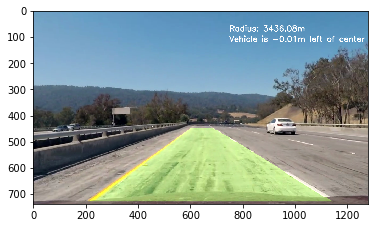

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
original = cv2.imread('./test_images/test8.jpg')
processed = process_image(original)
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
plt.imsave('./output_images/textSample.jpg', processed)
plt.imshow(processed)

In [32]:
pointsdemo = np.array([(1, 1), (2, 4), (3, 1), (9, 3)])
pointsdemo2 = np.array([(2, 2), (3, 5), (4, 2), (10, 4)])
plotydemo = np.linspace(0, pointsdemo.shape[0]-1, pointsdemo.shape[0] )
print('plotydemo: ', plotydemo)
print('5x plotydemo: ', plotydemo*5)
# get x and y vectors
x = pointsdemo[:,0]
y = pointsdemo[:,1]
l = pointsdemo2[:,0]
m = pointsdemo2[:,1]
# calculate polynomial
z = np.polyfit(x, y, 3)
q = np.polyfit(l, m, 3)
print('z[0] : ', z[0])
left_fitx = z[0]*plotydemo**2 + z[1]*plotydemo + z[2]
left_fitq = q[0]*plotydemo**2 + q[1]*plotydemo + q[2]
print('z: ',z)
print('q: ',q)
print('left_fitx: ' , left_fitx)
print('left_fitq: ' , left_fitq)
np.mean()

plotydemo:  [ 0.  1.  2.  3.]
5x plotydemo:  [  0.   5.  10.  15.]
z[0] :  0.434523809524
z:  [  0.43452381  -5.60714286  16.7797619  -10.60714286]
q:  [  0.43452381  -6.91071429  29.29761905 -32.42857143]
left_fitx:  [ 16.7797619   11.60714286   7.30357143   3.86904762]
left_fitq:  [ 29.29761905  22.82142857  17.21428571  12.47619048]


leftx:  15096


(720, 0)

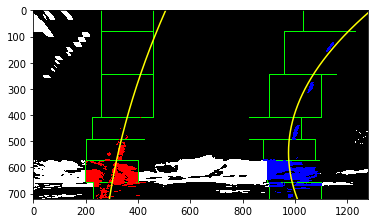

In [118]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
global frame_count
global prev_radius
global prev_offset
import random
%matplotlib inline
original = cv2.imread('./test_images/test9.jpg')
binary_warped = image_pipeline(original)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_line = Line()
right_line = Line()
if (left_line.detected == True and right_line.detected == True):
    left_fitx, right_fitx, leftx, rightx, lefty, righty = focused_search(binary_warped, left_line.current_fit, right_line.current_fit)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
else:
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = binary_warped.shape[1]/15
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    print('leftx: ', len(leftx))
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line.detected = True
    left_line.current_fit = left_fit
    left_line.allx = leftx
    left_line.ally = lefty
    left_line.line_base_pos = leftx_base

    right_line.detected = True
    right_line.current_fit = right_fit
    right_line.allx = rightx
    right_line.ally = righty
    right_line.line_base_pos = rightx_base


lane_offset = get_vehicle_position(binary_warped.shape, leftx_base, rightx_base)
left_line_ghostx =[] 
left_line_ghosty =[] 
right_line_ghostx = [] 
right_line_ghosty = []

combined_left = list(zip(left_line.allx, left_line.ally))
random.shuffle(combined_left)
left_line_ghostx[:], left_line_ghosty[:] = zip(*combined_left)
left_halfx = np.array_split(np.asarray(left_line_ghostx), 2)[0]
left_halfy = np.array_split(np.asarray(left_line_ghosty), 2)[0]
combined_leftx = np.append(leftx,left_halfx)
combined_lefty = np.append(lefty,left_halfy)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [30]:
original2 = cv2.imread('./test_images/test3.jpg')
binary_warpeddemo = video_binary_pipeline(original)
print('shape1: ' , original2.shape)
print('shape2: ' , binary_warpeddemo.shape)

hls_binary  (720, 1280)
rgb_binary  (720, 1280)
sobelx  (720, 1280)
sobely  (720, 1280)
direction_threshold  (720, 1280)
shape1:  (720, 1280, 3)
shape2:  (720, 1280, 3)


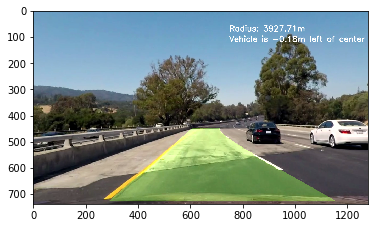

In [151]:
%matplotlib inline
original = cv2.imread('./test_images/test10.jpg')
final_image = process_image(original)

plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))